In [118]:
import pandas as pd
import altair as alt
import geopandas as gpd
import geoplot.crs as gcrs

In [119]:
windTurbine = pd.read_csv("data/opendata_wka_ib_gv_vb_sh_k_20231011.csv", sep=";")

# Data Cleaning and preperation

In [120]:
# data cleanup
# convertig the NABENHOEHE, ROTORDURCHMESSER from string to float and replace the ',' with '.'
windTurbine["NABENHOEHE"] = windTurbine["NABENHOEHE"].str.replace(",", ".").astype(float)
windTurbine["ROTORDURCHMESSER"] = windTurbine["ROTORDURCHMESSER"].str.replace(",", ".").astype(float)

In [121]:
# transform inbetriebnahme to datetime dd.mm.yyyy
windTurbine["GENEHMIGT_AM"] = pd.to_datetime(windTurbine["GENEHMIGT_AM"], format="%d.%m.%Y")
windTurbine["INBETRIEBNAHME"] = pd.to_datetime(windTurbine["INBETRIEBNAHME"], format="%d.%m.%Y")
windTurbine["DATENDATUM"] = pd.to_datetime(windTurbine["DATENDATUM"], format="%d.%m.%Y")

In [122]:
import pandas as pd
import numpy as np
import re

def convert_to_float(value):
    if pd.isnull(value):
        return np.nan
    match = re.search(r'\d+,\d+', value)
    if match:
        return float(match.group().replace(',', '.'))
    return np.nan

# Apply the function to your column
windTurbine['SCHALLLEISTUNGSPEGELConverted'] = windTurbine['SCHALLLEISTUNGSPEGEL'].apply(convert_to_float)


In [123]:
# the wind turbine with Inbetriebnhame on 1996-04-01 looks kinda sus since its is the type Tacke TW 600 
# but it shows that it produces 6000kw wich is alot for that date
# my resarch found out that the tacke tw 600 only has 600kw so we are going to correct it

#print(windTurbine[windTurbine["INBETRIEBNAHME"] == "1996-04-01"].head())

#correct the LEISTUNG to 600 for Entry 2900
windTurbine.loc[2900, "LEISTUNG"] = 600

In [124]:
# since there are 33 wind turbines with an older inbetriebnahme date than 1910 we are going to create a new
# dataframe for date analysis that does not consider these turbines
windTurbineDate = windTurbine[windTurbine["INBETRIEBNAHME"] > "1960-01-01"]

# they are also 10 turbines with a GENEHMIGT_AM date older than 1910 but with an Inbetriebnahme younger than 1910
# we are going to drop these turbines
windTurbineDate = windTurbineDate[windTurbineDate["GENEHMIGT_AM"] > "1960-01-01"]

In [125]:
# converting the used coordinates into lat/lon using pyproj
import pyproj

def convert_coordinates(df, easting_col, northing_col):
    # Define the projections
    utm_proj = pyproj.Proj(proj='utm', zone=32, ellps='WGS84')  # UTM coordinates (assuming zone 32)
    latlong_proj = pyproj.Proj(proj='latlong', datum='WGS84')  # LatLon with WGS84 datum used by GPS units and Google Earth

    # Apply the conversion to each row in the dataframe
    df['Longitude'], df['Latitude'] = pyproj.transform(utm_proj, latlong_proj, df[easting_col].values, df[northing_col].values)

    return df

# Convert the coordinates
windTurbine = convert_coordinates(windTurbine, 'OSTWERT', 'NORDWERT')



/tmp/ipykernel_730/2364807012.py:10: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  df['Longitude'], df['Latitude'] = pyproj.transform(utm_proj, latlong_proj, df[easting_col].values, df[northing_col].values)


In [ ]:
# Load the geojson data into a geopandas dataframe
gdf = gpd.GeoDataFrame.from_file("data/gemeinden_simplify20.geojson")

# Count the number of wind turbines per gemeinde
turbine_counts = windTurbine['GEMEINDE'].value_counts().reset_index()
turbine_counts.columns = ['GEN', 'count']

# Merge the turbine counts with the geopandas dataframe
merged = gdf.set_index('GEN').join(turbine_counts.set_index('GEN'))

# Fill NA/NaN values with 0 (instead of dropping them)
merged['count'] = merged['count'].fillna(0)

# Visualization

<GeoAxes: >

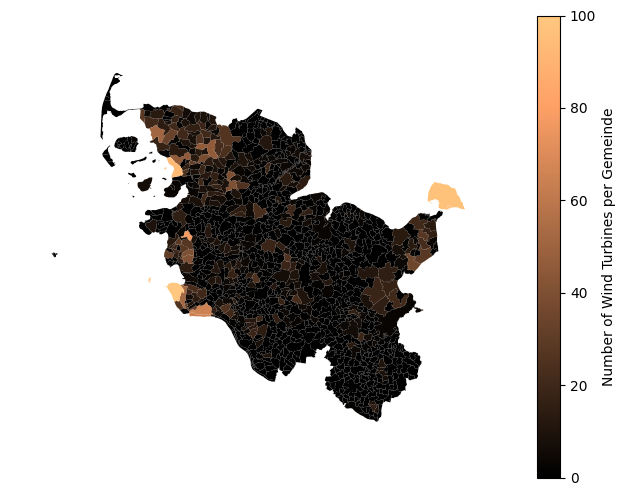

In [141]:


# Plot the data using geoplot
gplt.choropleth(
    merged, hue='count', projection=gcrs.WebMercator(), 
    linewidth=0.5,
    cmap="copper",
    legend=True, legend_kwargs={'label': "Number of Wind Turbines per Gemeinde"}
)


In [145]:
windTurbine[windTurbine["STATUS"] == "im Gen.Verf."].count()

KREIS                            391
GEMEINDE                         391
TYP                              381
HERSTELLER                       391
NABENHOEHE                       373
ROTORDURCHMESSER                 372
SCHALLLEISTUNGSPEGEL             266
LEISTUNG                         391
LEISTUNGSBEZUG                   391
OSTWERT                          391
NORDWERT                         391
GENEHMIGT_AM                       0
INBETRIEBNAHME                     0
STATUS                           391
BST_NR                           391
ANL_NR                           391
AKTENZEICHEN                     391
DATENDATUM                       391
DATENQUELLE                      391
SCHALLLEISTUNGSPEGELConverted    246
Longitude                        391
Latitude                         391
dtype: int64

In [132]:
chart = alt.Chart(windTurbine).mark_circle(aspect=True).encode(
    x='NABENHOEHE',
    y='LEISTUNG',
    size='ROTORDURCHMESSER',
    color='ROTORDURCHMESSER',
    tooltip=['NABENHOEHE', 'ROTORDURCHMESSER', 'LEISTUNG']
).properties(
    width=400 ,
    height=400
).interactive()

chart


alt.Chart(...)

<Axes: ylabel='count'>

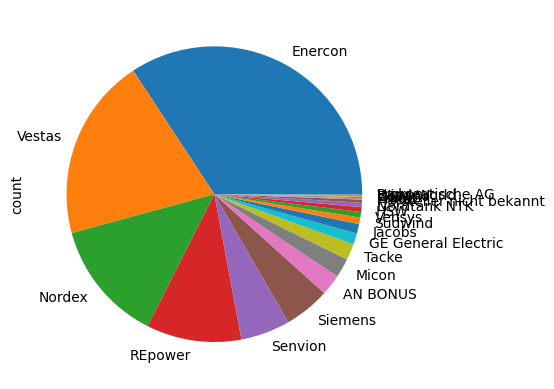

In [135]:
# print distrubition of the wind turbine manufacturers
windTurbine["HERSTELLER"].value_counts().plot(kind="pie")

In [136]:
# plot INBETRIEBNAHME and LEISTUNG with altair
import altair as alt


alt.Chart(windTurbineDate).mark_circle().encode(
    x='INBETRIEBNAHME',
    y='LEISTUNG',
    tooltip=['INBETRIEBNAHME', 'LEISTUNG']
).properties(
    width=400 ,
    height=400
).interactive()

alt.Chart(...)

In [137]:
import altair as alt
import pandas as pd
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

# Assuming windTurbine is your DataFrame and it has been loaded properly

# Calculate the difference in days between 'INBETRIEBNAHME' and 'GENEHMIGT_AM'
windTurbineDate['Time_Difference'] = (windTurbineDate['INBETRIEBNAHME'] - windTurbineDate['GENEHMIGT_AM']).dt.days

# Fill NaN values with the mean
windTurbineDate['Time_Difference'].fillna((windTurbineDate['Time_Difference'].mean()), inplace=True)

# Create a new column for the year
windTurbineDate['Year'] = windTurbineDate['GENEHMIGT_AM'].dt.year

# Group by Year and calculate the mean time difference
grouped = windTurbineDate.groupby('Year')['Time_Difference'].mean().reset_index()

# Create a LOESS trend line
X = grouped['Year'].values.reshape(-1,1)
y = grouped['Time_Difference'].values
model = make_pipeline(PolynomialFeatures(3), LinearRegression())
model.fit(X, y)
y_pred = model.predict(X)

# Create the chart
base = alt.Chart(grouped).encode(
    x=alt.X('Year', title='Year'),
    y=alt.Y('Time_Difference', title='Average Time Difference (in days)'),
    tooltip=['Year', 'Time_Difference']
)

line = base.mark_line().encode(
    x='Year',
    y='Time_Difference'
)

trend_line = alt.Chart(pd.DataFrame({'Year': grouped['Year'], 'Trend': y_pred})).mark_line(color='red').encode(
    x='Year',
    y='Trend'
)

chart = (line + trend_line).properties(
    title='Average Time Difference from Approval to First Energy Produced Over the Years'
)

chart


alt.LayerChart(...)

In [138]:
import altair as alt
import pandas as pd

# Assuming windTurbine is your DataFrame and it has been loaded properly

# Calculate the difference in days between 'INBETRIEBNAHME' and 'GENEHMIGT_AM'
windTurbineDate['Time_Difference'] = (windTurbineDate['INBETRIEBNAHME'] - windTurbineDate['GENEHMIGT_AM']).dt.days

# Create a new column for the year
windTurbineDate['Year'] = windTurbineDate['GENEHMIGT_AM'].dt.year

# Create the boxplot
chart = alt.Chart(windTurbineDate).mark_boxplot().encode(
    x='Year:O',
    y=alt.Y('Time_Difference:Q', title='Time Difference (in days)'),
    tooltip=['Year', 'Time_Difference']
).properties(
    title='Boxplot of Time Difference from Approval to First Energy Produced Over the Years'
)

chart


alt.Chart(...)